## Crude Oil

### Weekly

C:\Users\dipes\AppData\Local\Temp\ipykernel_22704\569771606.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


Epoch 1/70
65/65 [==============================] - 7s 77ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 2/70
65/65 [==============================] - 11s 167ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 3/70
65/65 [==============================] - 4s 67ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 4/70
65/65 [==============================] - 6s 98ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/70
65/65 [==============================] - 18s 283ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 6/70
65/65 [==============================] - 20s 308ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 7/70
65/65 [==============================] - 6s 88ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 8/70
65/65 [==============================] - 4s 69ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 9/70
65/65 [==============================] - 5s 74ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 10/70
65/65 [==============================] - 5s 77ms/step - loss: 0.0044 - val_loss: 0.0028
Epo

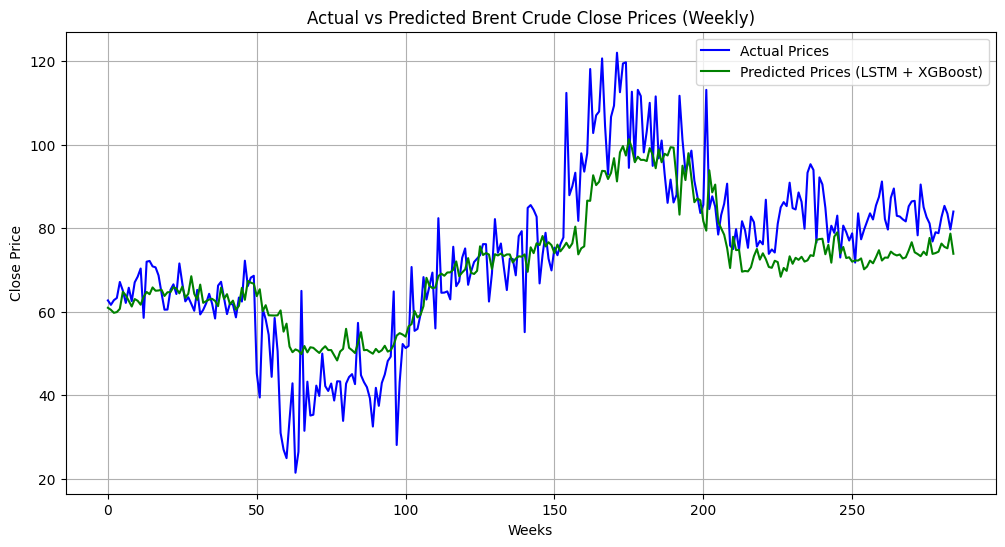

1/1 [==============================] - 0s 35ms/step

Brent Crude Oil - Future Weekly Predictions:
        Date  Predicted Close Price
0 2024-09-08              73.870560
1 2024-09-15              74.126930
2 2024-09-22              75.250618
3 2024-09-29              73.196991
4 2024-10-06              73.181084


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_w2.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Features and target
features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_12', 'EMA_26', 'RSI',
    'S&P500_Close', 'S&P500_ATR', 'S&P500_EMA_12', 'S&P500_EMA_26', 'S&P500_RSI',
    'CBOE_Close', 'CBOE_ATR', 'CBOE_EMA_12', 'CBOE_EMA_26', 'CBOE_RSI',
    'USDI_Close', 'USDI_ATR', 'USDI_EMA_12', 'USDI_EMA_26', 'USDI_RSI'
]
target = 'Close'

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Sequence creator
def create_sequences(data, time_steps=350):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 350
X, y = create_sequences(scaled_df.values, time_steps)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM
lstm_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# LSTM output for XGBoost input
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)

# Combine for XGBoost
X_train_xgb = np.hstack([X_train.reshape(X_train.shape[0], -1), lstm_train_pred])
X_test_xgb = np.hstack([X_test.reshape(X_test.shape[0], -1), lstm_test_pred])

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.06, max_depth=5, random_state=42)
xgb_model.fit(X_train_xgb, y_train)

# Predictions
xgb_preds = xgb_model.predict(X_test_xgb)

# Inverse scale
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
xgb_preds_inv = scaler_target.inverse_transform(xgb_preds.reshape(-1, 1))

# RMSE & Accuracy
rmse = np.sqrt(mean_squared_error(y_test_inv, xgb_preds_inv))
accuracy = 100 - np.mean(np.abs((y_test_inv - xgb_preds_inv) / y_test_inv)) * 100
print(f"\nRMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(xgb_preds_inv, label='Predicted Prices (LSTM + XGBoost)', color='green')
plt.title('Actual vs Predicted Brent Crude Close Prices (Weekly)')
plt.xlabel('Weeks')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


future_weeks = 5
last_sequence = X_test[-1]
future_preds = []

for _ in range(future_weeks):
    lstm_out = lstm_model.predict(last_sequence[np.newaxis, :, :])
    xgb_input = np.append(last_sequence.reshape(-1), lstm_out).reshape(1, -1)
    next_pred_scaled = xgb_model.predict(xgb_input)
    next_pred_actual = scaler_target.inverse_transform(next_pred_scaled.reshape(-1, 1))[0][0]
    future_preds.append(next_pred_actual)
    new_week = last_sequence[-1].copy()
    last_sequence = np.append(last_sequence[1:], [new_week], axis=0)

future_dates = pd.date_range(start='2024-09-08', periods=future_weeks, freq='W-SUN')
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Close Price': future_preds})
print("\nBrent Crude Oil - Future Weekly Predictions:")
print(future_df)


### Monthly

Epoch 1/70
18/18 [==============================] - 2s 16ms/step - loss: 0.0283 - val_loss: 0.0033
Epoch 2/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 3/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 4/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 5/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 6/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 7/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0079
Epoch 8/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0102
Epoch 9/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 10/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 11/70
18/18 

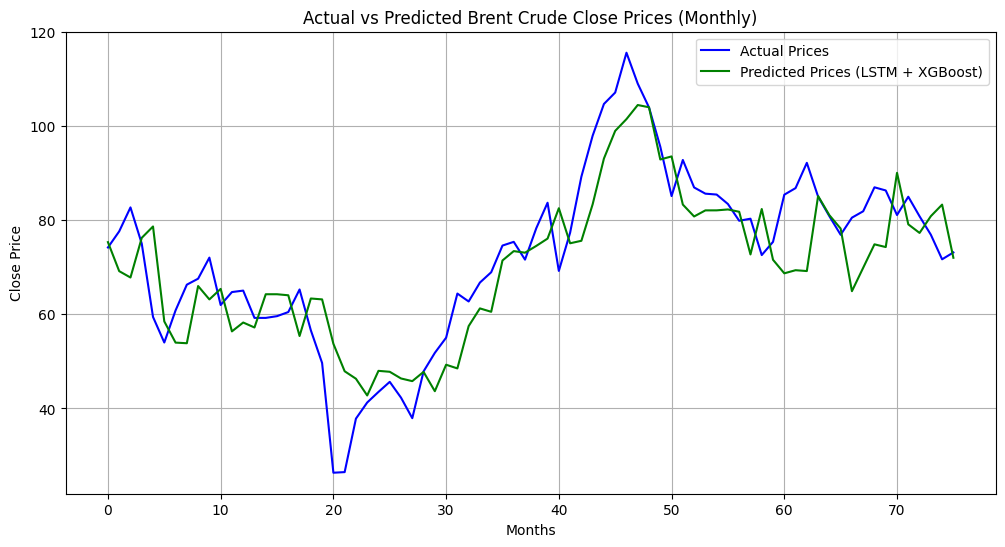

1/1 [==============================] - 0s 23ms/step

Monthly Brent Crude Predictions (Starting Nov 1, 2024):
        Date  Predicted Close Price
0 2024-11-01              72.024429
1 2024-12-01              76.074913
2 2025-01-01              75.710121
3 2025-02-01              76.044296
4 2025-03-01              76.100594


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_m2.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_10', 'EMA_20', 'RSI',
    's&p_500_Close', 's&p_500_ATR', 's&p_500_EMA_12', 's&p_500_EMA_26', 's&p_500_RSI',
    'cboe_Close', 'cboe_ATR', 'cboe_EMA_12', 'cboe_EMA_26', 'cboe_RSI',
    'usdi_Close', 'usdi_ATR', 'usdi_EMA_12', 'usdi_EMA_26', 'usdi_RSI'
]
target = 'Close'

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Create sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_df.values, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Predictions from LSTM for XGBoost input
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)

X_train_xgb = np.hstack([X_train.reshape(X_train.shape[0], -1), lstm_train_pred])
X_test_xgb = np.hstack([X_test.reshape(X_test.shape[0], -1), lstm_test_pred])

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.085, max_depth=5, random_state=42)
xgb_model.fit(X_train_xgb, y_train)

# Predict and inverse scale
xgb_preds = xgb_model.predict(X_test_xgb)
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
xgb_preds_inv = scaler_target.inverse_transform(xgb_preds.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_inv, xgb_preds_inv))
accuracy = 100 - np.mean(np.abs((y_test_inv - xgb_preds_inv) / y_test_inv)) * 100

print(f"\nRMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(xgb_preds_inv, label='Predicted Prices (LSTM + XGBoost)', color='green')
plt.title('Actual vs Predicted Brent Crude Close Prices (Monthly)')
plt.xlabel('Months')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Forecast Future Prices
future_months = 5
last_seq = X_test[-1]
future_predictions = []

for _ in range(future_months):
    lstm_out = lstm_model.predict(last_seq[np.newaxis, :, :])
    xgb_input = np.append(last_seq.reshape(-1), lstm_out).reshape(1, -1)
    next_pred_scaled = xgb_model.predict(xgb_input)
    next_pred_actual = scaler_target.inverse_transform(next_pred_scaled.reshape(-1, 1))[0][0]
    future_predictions.append(next_pred_actual)

    # Update sequence: use last step features as next input
    next_features = last_seq[-1].copy()
    last_seq = np.append(last_seq[1:], [next_features], axis=0)

# Future date range (starting Nov 2024)
future_dates = pd.date_range(start='2024-11-01', periods=future_months, freq='MS')

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': future_predictions
})

print("\nMonthly Brent Crude Predictions (Starting Nov 1, 2024):")
print(future_df)
